In [1]:
# Recommendation: `conda install --channel conda-forge geopandas`
# https://imai.fas.harvard.edu/research/files/redist.pdf
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm

In [2]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1 
    else:
        return len(geometry.geoms)

In [3]:
with open("../states.json", "r") as f:
    states = json.load(f)
state = "PA"
DEGREE_LIMIT = 0
voting_precincts = gpd.read_file(states[state]["FILE"])
voting_precincts = voting_precincts.to_crs("EPSG:4269")
# voting_precincts = voting_precincts.dissolve(by="COUNTYFP", aggfunc="sum")
n_districts = states[state]["NUM_OF_DISTRICTS"]
pop = states[state]["POPULATION"]
d_votes = states[state]["DEMOCRAT_VOTES"]
r_votes = states[state]["REPUBLICAN_VOTES"]
print(voting_precincts.columns)
voting_precincts.sample(n=1)

KeyboardInterrupt: 

In [ ]:
# voting_precincts = voting_precincts.to_crs("EPSG:4269")
# voting_precincts['GEOID20'] = voting_precincts['GEOID20'].astype(str)

print([x for x in voting_precincts.columns if "POP" in x.upper()])
print([x for x in voting_precincts.columns if "D" in x.upper()])
print(voting_precincts.shape)
# voting_precincts.sample(n=5)

['TOTPOP19', 'TOTPOP10', 'HPOP19', 'HPOP10', 'NHPOP19', 'NHPIPOP19', 'NHPOP10', '2MOREPOP19', '2MOREPOP10', 'ASIANPOP19', 'ASIANPOP10', 'AMINPOP19', 'AMINPOP10', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WPOP10']
['GEOID20', 'G18USSDCAS', 'VTDST', 'G18GOVDWOL', 'VTDST20', 'NAMELSAD20', 'LSAD20', 'G16AUDGSWE', 'G16AUDRBRO', 'G16PREDCLI', 'G16AUDDDEP', 'G16USSDMCG', 'G16TREDTOR', 'G16ATGDSHA', 'ALAND20', 'G16AUDLMIN', 'VTDI20']
(9178, 72)


In [ ]:
voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
voting_precincts['RP_LON'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
voting_precincts['RP_LAT'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(voting_precincts.shape)
# voting_precincts.sample(n=5)

C:\Users\yagne\AppData\Local\Temp\ipykernel_16564\1766291162.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263


(9178, 75)


In [ ]:
orig_voting = voting_precincts[[d_votes, r_votes]].sum()/(voting_precincts[[d_votes, r_votes]].sum().sum())
orig_voting

G18GOVDWOL    0.586676
G18GOVRWAG    0.413324
dtype: float64

In [ ]:
def entropy_score_parta_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score = entropy([dem_prop_1, rep_prop_1], base=2)

    # Will always minimize, for entropy negate
    return -score

def entropy_score_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = entropy([dem_prop_1, rep_prop_1], base=2)

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = entropy([dem_prop_2, rep_prop_2], base=2)

    score = (score_1+score_2)/2 # Average of both
    # Will always minimize, for entropy negate
    return -score
    

def abs_diff_parta_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score = abs(dem_prop_1-rep_prop_1) 
    return score
    
def abs_diff_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = abs(dem_prop_1-rep_prop_1) 

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = abs(dem_prop_2-rep_prop_2)

    score = (score_1+score_2) # Average of both
    return score

def match_statewide_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    orig_dem = kwargs["orig_dem"]
    orig_rep = kwargs["orig_rep"]
    # Always takes in both dataframes
    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = abs(dem_prop_1-orig_dem)+abs(rep_prop_1-orig_rep)

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = abs(dem_prop_2-orig_dem)+abs(rep_prop_2-orig_rep)

    score = (score_1+score_2)/2 # Average of both
    return score


def equalize_voting(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes
    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])

    score = abs(dem_prop_1-dem_prop_2) 
    return score




In [ ]:
# %%time
def split_this(df, n_districts, score_fn=abs_diff_parta_fn, n_split=1, pop_col = "POPULATION", dem_col = "G18GOVD", rep_col = "G18GOVR",  n_sample_angles=None, degree_limit = 0, dissolve_check = False):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df[pop_col].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df[pop_col]).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df[pop_col]).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        # df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        if n_sample_angles:
            start_angles = np.random.choice(start_angles, size=n_sample_angles)
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in tqdm(start_angles):
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, pop_col]
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']

            ## Check if angle range loops past 360 for conditions:
            a1, a2 = d, final_angle

            # If specified, skip past any second hand angle that is not far away from the first handle angle.
            if abs(a2 - a1) <= degree_limit:
                continue

            if a1 < a2:
                    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
            elif a1 > a2:
                    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

            # Dissolve Check for Non-Contiguity
            if dissolve_check:
                dissolved_df = df.dissolve(by=f'SPLIT_{n_split}')
                dissolved_df['disjoints'] = dissolved_df['geometry'].apply(lambda x: count_disjoints(x))
                dissolved_pieces = dissolved_df['disjoints'].sum()
            else:
                dissolved_pieces = 0

            df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)


            # Metric Calculation, Change to any function chosen.
            score = score_fn(df_a, df_b, dem_col, rep_col, orig_dem=orig_voting[dem_col], orig_rep=orig_voting[rep_col])
            angle_ranges.append({"start":d, "end":final_angle, "score":score, "disjoints": dissolved_pieces})


        ars = pd.DataFrame(angle_ranges)
        # ars['entropy_prod'] = (ars['entropy_a']*ars["entropy_b"])/(ars['entropy_a']+ars["entropy_b"])
        # ars = ars.sort_values("entropy_prod", ascending=False).reset_index(drop=True)
        ars = ars.sort_values(["disjoints","score"], ascending=True).reset_index(drop=True)

        a1, a2 = ars.iloc[0]["start"], ars.iloc[0]["end"]
        ## Check if angle range loops past 360 for conditions:
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles, degree_limit=degree_limit, score_fn=score_fn)
        split_this(df_b, part_b, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles, degree_limit=degree_limit, score_fn=score_fn)

        
    else:
        holder.append(df)

holder = []   
split_this(df=voting_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes, degree_limit=DEGREE_LIMIT, score_fn=abs_diff_mean_fn)

100%|██████████| 360/360 [00:03<00:00, 111.36it/s]


In [ ]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [ ]:
all_districts['DISTRICT'].nunique()

18

In [ ]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [ ]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
all_districts.groupby("SHUFFLED").sum()[pop]

12791530.0


SHUFFLED
0.0     712185.895776
1.0     713641.778089
2.0     707974.233966
3.0     710099.998134
4.0     713209.467299
5.0     710531.169783
6.0     711424.428654
7.0     711474.205435
8.0     709650.113405
9.0     706785.762619
10.0    709906.703060
11.0    710570.715141
12.0    709264.328986
13.0    712736.903786
14.0    709685.229260
15.0    711052.379123
16.0    711393.742724
17.0    709942.944759
Name: TOTPOP19, dtype: float64

In [ ]:
all_districts.columns

Index(['GEOID20', 'G18GOVRWAG', 'G18USSDCAS', 'NAME', 'G18USSLKER', 'VTDST',
       'STATEFP', 'G18USSGGAL', 'COUNTYFP', 'G18USSRBAR', 'G18GOVDWOL',
       'G18GOVGGLO', 'G18GOVLKRA', 'VTDST20', 'G16TRERVOI', 'NAMELSAD20',
       'AWATER20', 'LSAD20', 'G16AUDGSWE', 'NAME20', 'G16AUDRBRO',
       'G16PRERTRU', 'G16TRELBAB', 'COUNTYFP20', 'G16TREGCOM', 'G16PREDCLI',
       'STATEFP20', 'G16USSRTOO', 'G16PRECCAS', 'G16USSLCLI', 'G16AUDDDEP',
       'G16USSDMCG', 'FUNCSTAT20', 'INTPTLAT20', 'G16TREDTOR', 'G16ATGRRAF',
       'G16ATGDSHA', 'G16PREGSTE', 'ALAND20', 'G16PRELJOH', 'G16AUDLMIN',
       'INTPTLON20', 'VTDI20', 'MTFCC20', 'TOTPOP19', 'TOTPOP10', 'HPOP19',
       'HCVAP19', 'HPOP10', 'NHPICVAP19', 'NHCVAP19', 'NHPOP19', 'NHPIPOP19',
       'NHPOP10', '2MOREPOP19', '2MORECVAP1', '2MOREPOP10', 'ASIANPOP19',
       'ASIANCVAP1', 'ASIANPOP10', 'AMINPOP19', 'AMINCVAP19', 'AMINPOP10',
       'BCVAP19', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WCVAP19',
       'WPOP10', 'CVAP19', 'geo

In [ ]:
all_districts[['geometry', pop, r_votes, d_votes, 'DISTRICT', 'SHUFFLED'] + split_columns].to_file(f"{state}_comp.shp")

c:\Users\yagne\anaconda3\envs\common\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

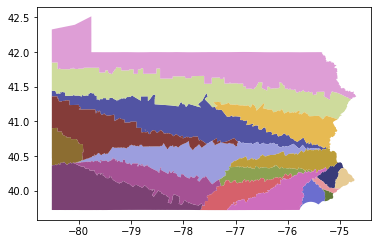

In [ ]:
districts_df = all_districts.dissolve(by="SHUFFLED")
districts_df.plot(cmap="tab20b")

## Step by Step Review

In [ ]:
def split_review(input_df, split, split_cols, plot_party=False, figsize = (8,6), save=None):
    input_df['TEMP_DISTRICT'] = input_df.apply(splits_to_regions_binary, splits=split_cols[:split], axis=1)
    n_districts = input_df['TEMP_DISTRICT'].nunique()
    # random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
    random_districts = np.linspace(0,n_districts-1,n_districts)
    shuffle_dict = dict(zip(input_df["TEMP_DISTRICT"].unique(), random_districts))
    input_df["TEMP_DISTRICT"] = input_df["TEMP_DISTRICT"].apply(lambda x: shuffle_dict[x])

    districts_df = input_df.dissolve(by = "TEMP_DISTRICT", aggfunc={"TEMP_DISTRICT": "first", d_votes: "sum", r_votes: "sum"})
    districts_df["Dem_Ratio"] = districts_df[d_votes]/(districts_df[d_votes] + districts_df[r_votes])
    districts_df["Rep_Ratio"] = districts_df[r_votes]/(districts_df[d_votes] + districts_df[r_votes])

    
    fig, ax = plt.subplots(1,1, figsize=figsize)

    if plot_party:
        base = districts_df.plot(ax=ax, cmap="RdBu", column="Dem_Ratio", legend=True, vmin=0, vmax=1, edgecolor='black')
        dem_wins = districts_df.loc[districts_df["Dem_Ratio"] >= districts_df["Rep_Ratio"]].shape[0]
        rep_wins = districts_df.loc[districts_df["Dem_Ratio"] < districts_df["Rep_Ratio"]].shape[0]
        title = f"Districts: {districts_df.shape[0]} | D-R: {dem_wins}-{rep_wins}"
    else:
        base = districts_df.plot(ax=ax, cmap="tab20b", edgecolor='black')
        title = f"Districts - {districts_df.shape[0]}"
    

    points = []
    for x in range(2**split):
        sub = input_df.loc[input_df['TEMP_DISTRICT'] == x]
        if sub.shape[0] == 0:
            continue
        pop_center_LON = (sub['RP_LON'] * sub[pop]).sum()/sub[pop].sum()
        pop_center_LAT =  (sub['RP_LAT'] * sub[pop]).sum()/sub[pop].sum()
        point = shapely.geometry.Point(pop_center_LON, pop_center_LAT)
        points.append(point)
    pop_center_df = gpd.GeoDataFrame(geometry=points)
    pop_center_df.plot(ax=ax, color="white", linewidth=1.0, edgecolor="black")
    plt.title(title)
    if save:
        fig.savefig(save)
    plt.show()

    return districts_df


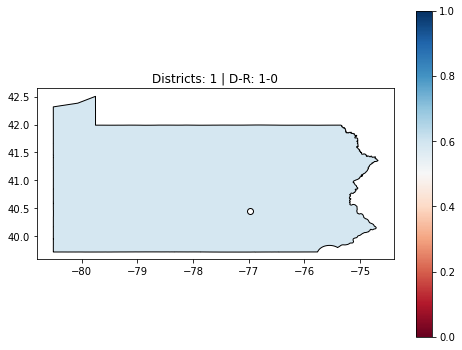

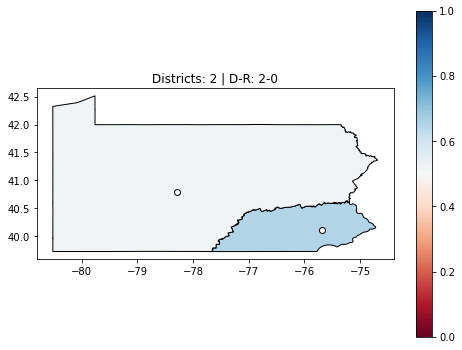

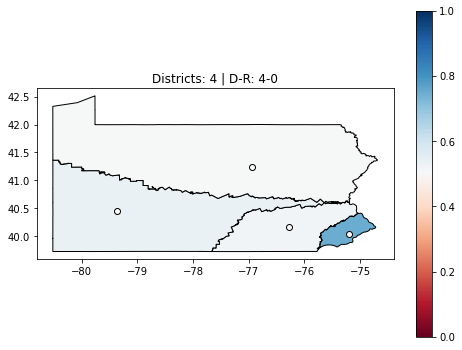

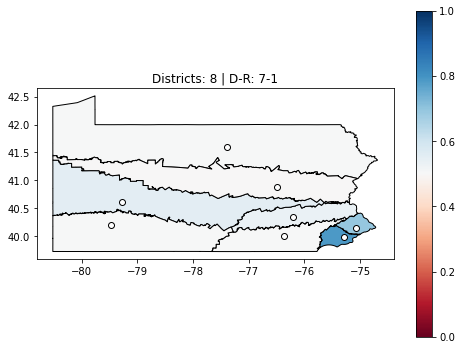

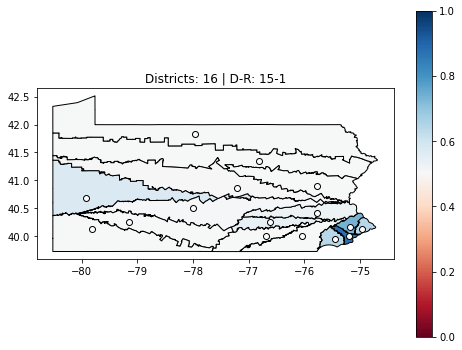

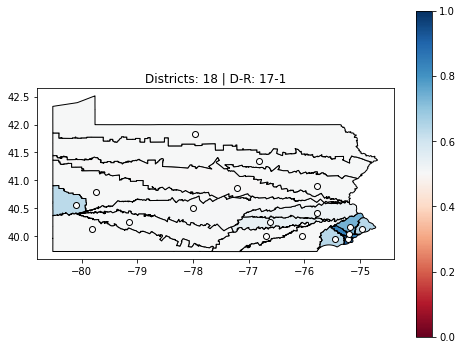

In [ ]:
for s in range(len(split_columns)+1):
    _ = split_review(input_df=all_districts, split=s, split_cols=split_columns, plot_party=True)

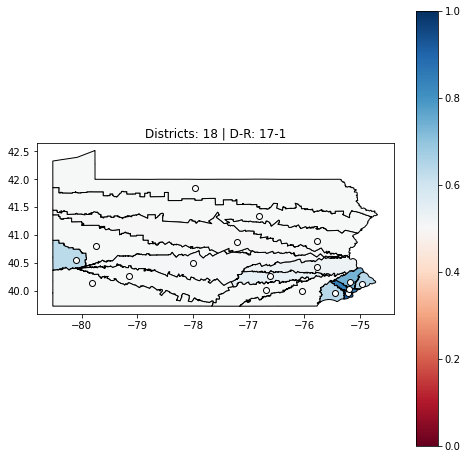

In [ ]:
_ = split_review(input_df=all_districts, split=5, split_cols=split_columns, plot_party=True, figsize=(8,8), save=f"{state}_final.png")

In [ ]:
_.sort_values("Rep_Ratio")

,geometry,TEMP_DISTRICT,G18GOVDWOL,G18GOVRWAG,Dem_Ratio,Rep_Ratio
TEMP_DISTRICT,,,,,,
0.0,"POLYGON ((-75.29466 39.86601, -75.29466 39.866...",0.0,259674.261000,27196.815631,0.905195,0.094805
1.0,"POLYGON ((-75.14033 39.96589, -75.14023 39.966...",1.0,204713.129023,38287.280582,0.842439,0.157561
3.0,"POLYGON ((-75.10722 40.04099, -75.10576 40.039...",3.0,252299.691472,90542.574842,0.735906,0.264094
4.0,"POLYGON ((-75.04381 40.02869, -75.04297 40.029...",4.0,167591.000000,94159.000000,0.640271,0.359729
2.0,"POLYGON ((-75.77162 39.77768, -75.77129 39.777...",2.0,211925.771432,119299.833497,0.639823,0.360177
9.0,"POLYGON ((-80.02467 40.41057, -80.02486 40.410...",9.0,195905.006651,112572.769652,0.635070,0.364930
7.0,"MULTIPOLYGON (((-76.07097 40.21546, -76.07110 ...",7.0,154430.092726,130198.496175,0.542567,0.457433
8.0,"POLYGON ((-75.35393 40.31132, -75.35469 40.310...",8.0,137602.264760,124144.603262,0.525707,0.474293
11.0,"MULTIPOLYGON (((-77.18842 40.25147, -77.18825 ...",11.0,131079.879230,128274.751234,0.505408,0.494592
